# Figure S11. Comparison of models based on true, null, or no heterogeneity maps

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [23]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, datasets, stats
from modeling.check_fit import load_cmaes_hist

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

Load data:

In [12]:
all_stats = {}
all_data = {}
all_I_E = {}
for alt in ['main', '6maps_rot', '4maps', '2maps', 'nmda_gabaa', 'homo', 'node']:
    all_stats[alt] = pd.read_csv(f"p_pnc200_{alt}_IE_age_stats.csv", index_col=0)
    all_data[alt] = pd.read_csv(f"pnc200_{alt}_data.csv", index_col=0)
    all_I_E[alt] = pd.read_csv(f"pnc200_{alt}_IE.csv", index_col=0)

## A. Influence of selected maps patterns on the spatial pattern of E-I ratio age effects

Load original maps:

In [4]:
maps_parcellated = datasets.load_maps('schaefer-100', '6maps')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Create a set of null (rotated) maps:

In [7]:
# generate spin rotated parcel indices
rotated_indices = stats.get_rotated_parcels('schaefer-100', 1, return_indices=True, space='fsaverage', seed=0).flatten()
# rotate all original maps using the rotation
# indices to create a set of surrogate maps
surrogate_maps = np.zeros(maps_parcellated.shape)
surrogate_maps[rotated_indices, :] = maps_parcellated.values
surrogate_maps = pd.DataFrame(surrogate_maps, index=maps_parcellated.index, columns=maps_parcellated.columns)

Plot the surrogate maps (for sanity check; they are not put in the figure):

myelinmap surrogate


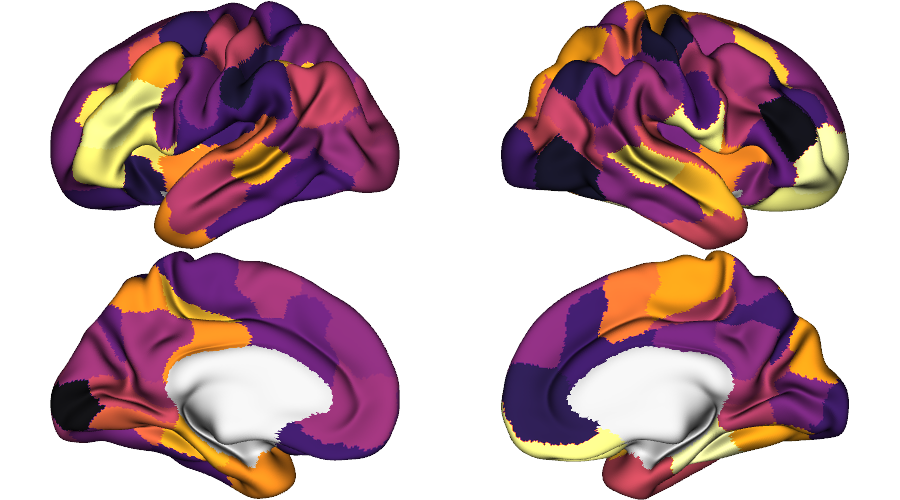

thickness surrogate


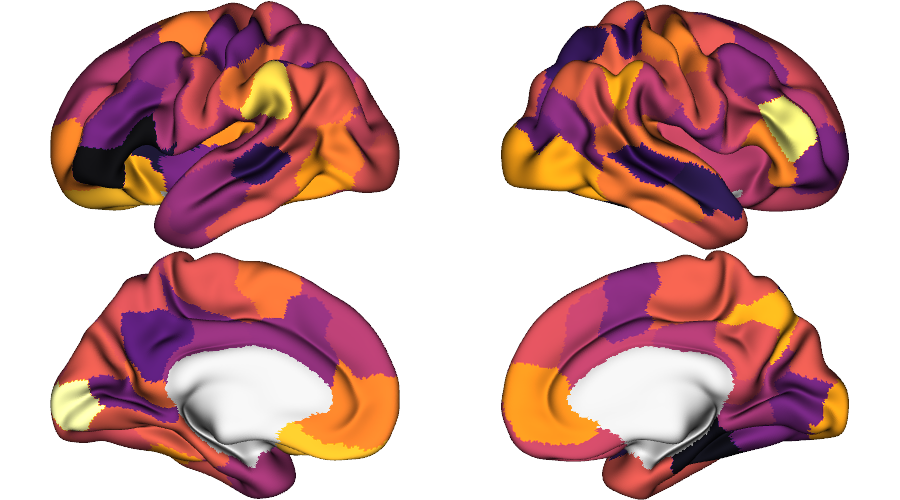

fcgradient01 surrogate


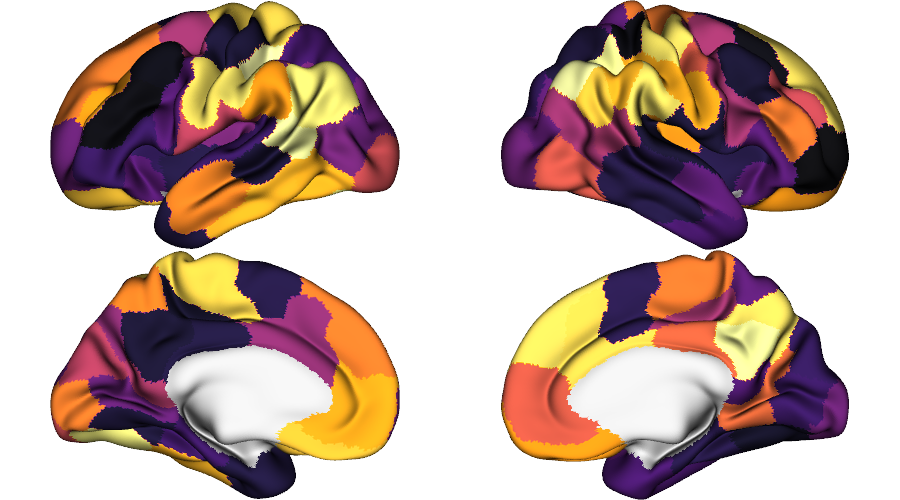

genepc1 surrogate


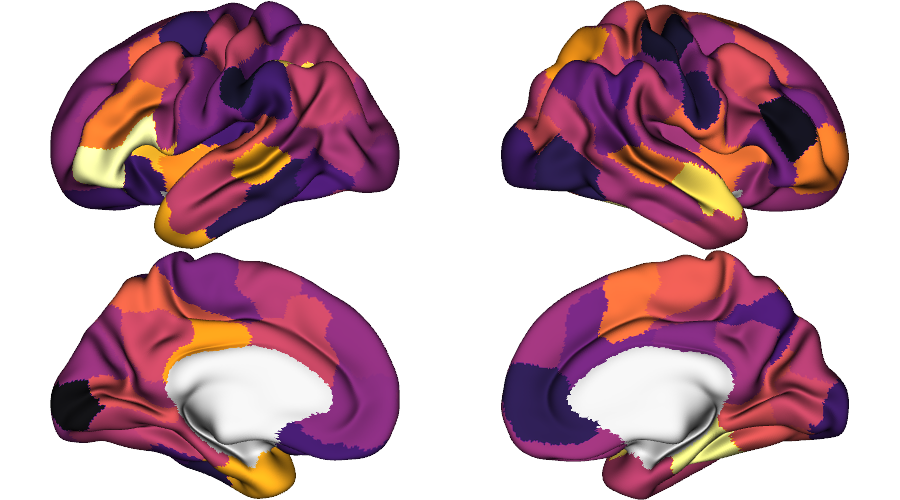

nmda surrogate


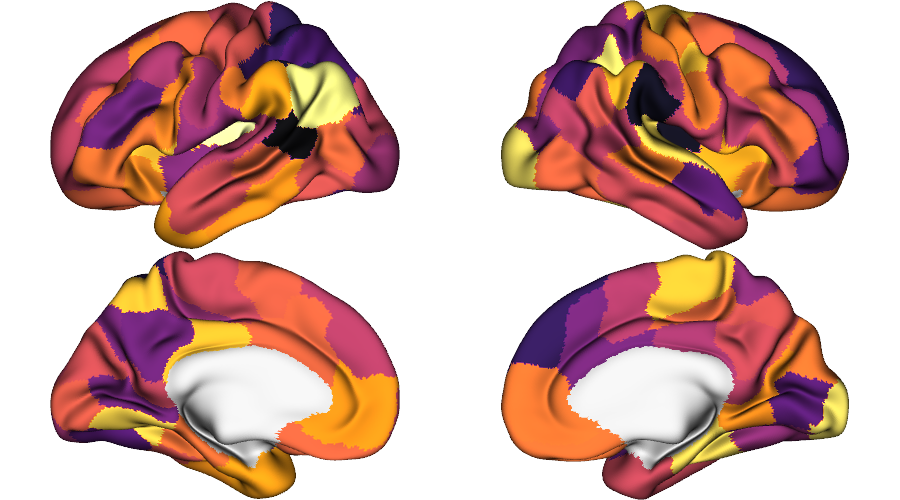

gabaa surrogate


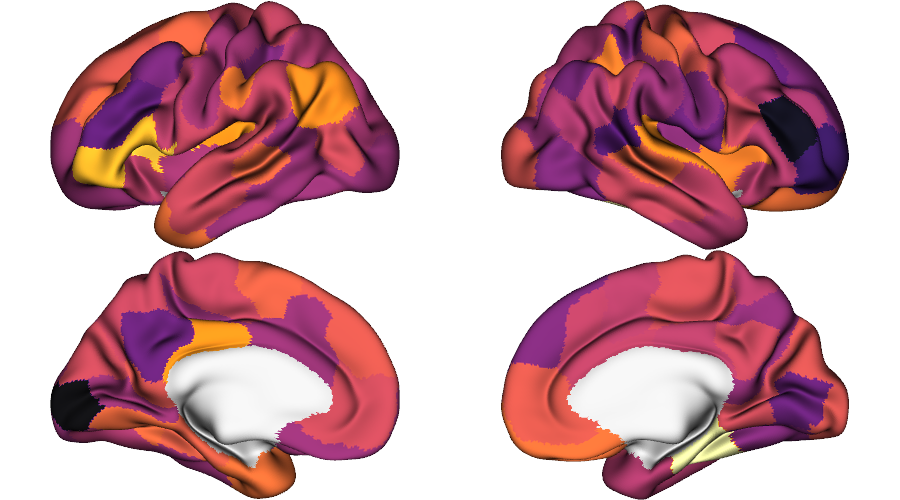

In [8]:
for col in surrogate_maps.columns:
    print(col, "surrogate")
    display(
        plot.plot_surface(
            transform.deparcellate_surf(surrogate_maps[col], 'schaefer-100', concat=True, space='fsaverage'), 
            'fsaverage', mesh_kind='semi-inflated',
            cmap='inferno', cbar=False, layout_style='grid',
        )
    )

Write them to a text file which is used in BNM simulation-optimization runs on the subsample subjects based on these null maps:

In [9]:
np.savetxt(os.path.join(INPUT_DIR, '6maps_rot_schaefer-100_zscore.txt'), surrogate_maps.values.T, fmt="%f")

The data of optimal simulations based on these runs is already loaded at the beginning of this notebook.

### (left) Effect of age on E-I ratio using null maps

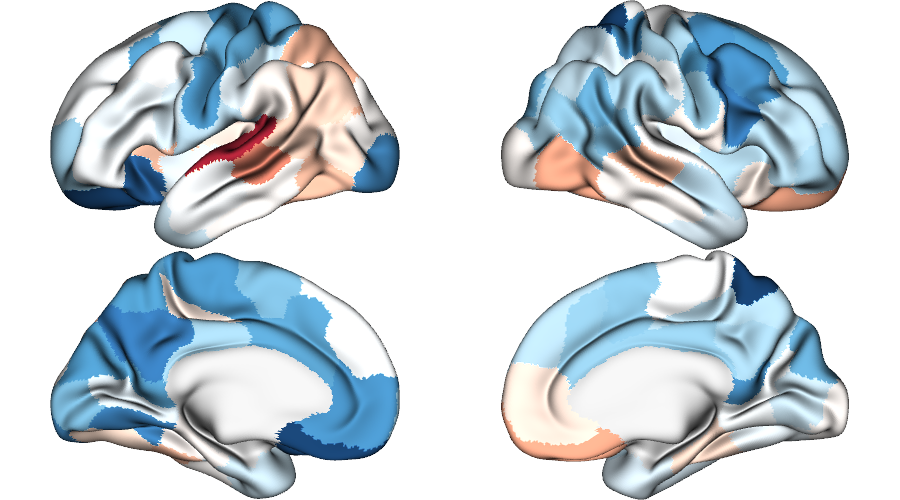

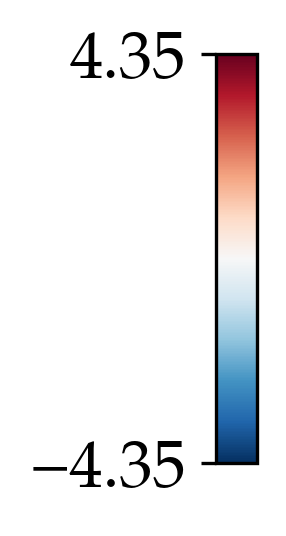

In [10]:
vmin = min(all_stats['6maps_rot']['t'].values.min(), -all_stats['6maps_rot']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['6maps_rot']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main age effect map (the plot is not reported in the figure):

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.21389570519111 ; p-vlaue: 0.018
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.5026404412707627 ; p-vlaue: 0.009


<Axes: xlabel='E-I ratio age effect\n(Null maps)', ylabel='E-I ratio age effect\n(True maps)'>

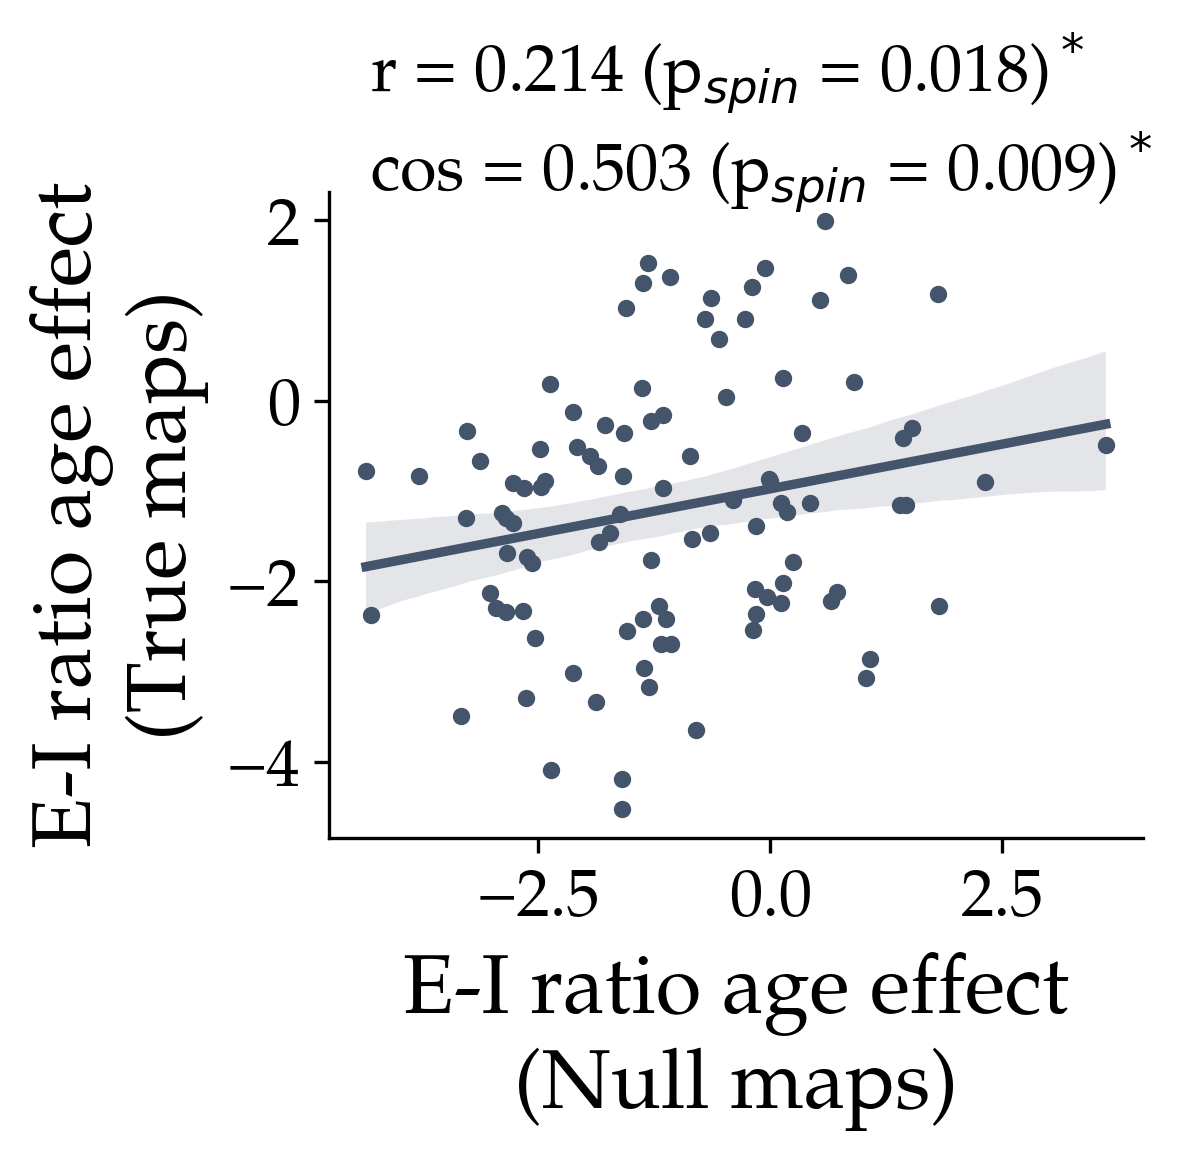

In [11]:
plot.reg_plot(
    all_stats['6maps_rot'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='E-I ratio age effect''\n(Null maps)',
    ylabel='E-I ratio age effect''\n(True maps)'
)

### (right) Spatial correlation of true and null maps with the E-I ratio age effects observed across models using alternative maps/approaches for regional parameters heterogeneity

In [13]:
# define alternatives used in this analysis
het_alts = ['main', '6maps_rot', '4maps', '2maps', 'nmda_gabaa', 'homo', 'node']
het_alt_labels = ['6 Maps', '6 Null Maps', 'T1w/T2w, FCG1,\nNMDA & GABA$_{A/BZ}$', 'T1w/T2w & FCG1', r'NMDA & GABA$_{A/BZ}$', 'Homogeneous', 'Node-based\nheterogeneous']
# combine all T maps
ts_het = pd.DataFrame({k:all_stats[k]['t'] for k in het_alts})
# rename true and null map columns to print names
map_names = [
    "T1w/T2w",
    "Thickness",
    "FC G1",
    "Gene PC1",
    "NMDA",
    r"GABA$_{A/BZ}$"
]
maps_parcellated.columns = map_names
surrogate_maps.columns = [f'Rotated {map_name}' for map_name in map_names]
# calculate correlations of all alternatives with the six true maps
corr_het, p_corr_het, _ = stats.spin_test_parcellated(maps_parcellated, ts_het, parcellation_name='schaefer-100')
# calculate correlations of main and 6maps_rot age effects with the six null maps
null_corr_het, p_null_corr_het, _ = stats.spin_test_parcellated(surrogate_maps, ts_het.iloc[:, :2], parcellation_name='schaefer-100')

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


Plot the correlations as a combined heatmap:

Text(7.5, 3, 'Null (rotated) maps')

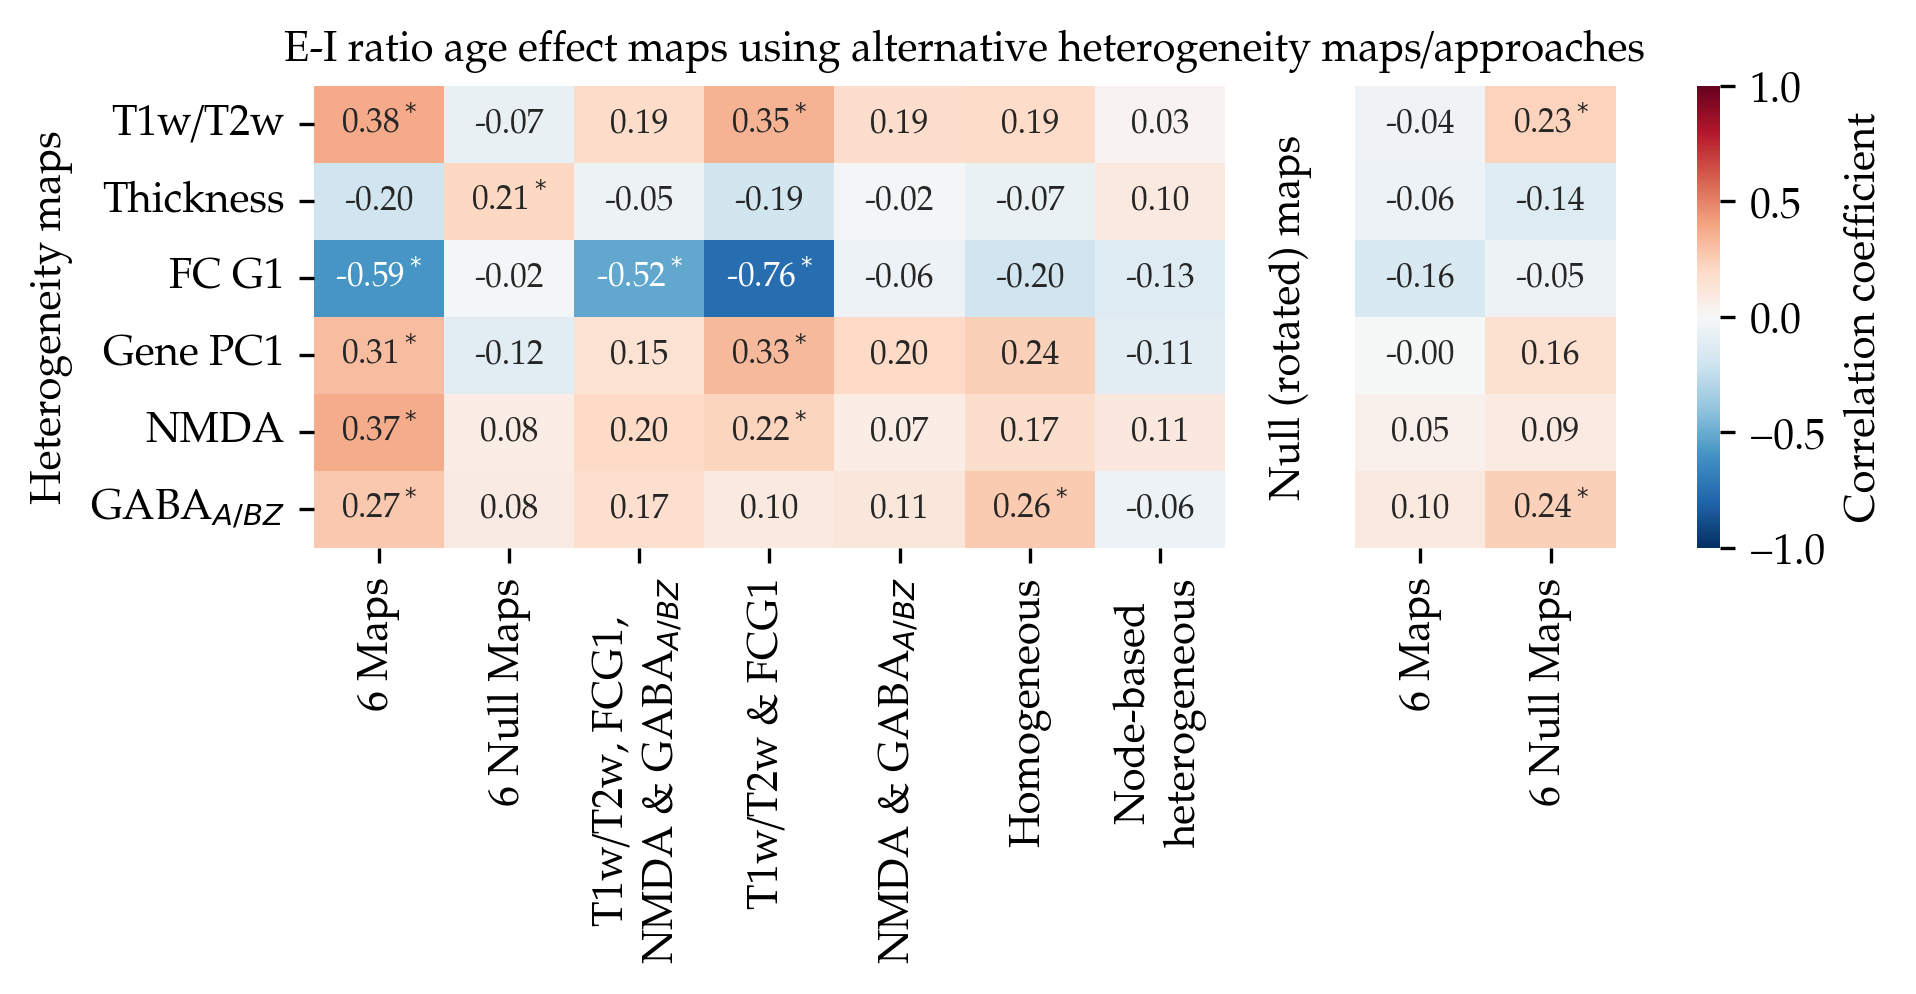

In [14]:
corr_het_combined = pd.concat([
    corr_het.T.reset_index(drop=True), 
    pd.DataFrame(np.full(6, np.NaN)), # adds an empty column for the space to write "Null (rotated) maps"
    null_corr_het.T.reset_index(drop=True)
],axis=1, ignore_index=True
)
p_corr_het_combined = pd.concat([
    p_corr_het.T.reset_index(drop=True), 
    pd.DataFrame(np.full(6, np.NaN)), 
    p_null_corr_het.T.reset_index(drop=True).iloc[:, :2]
],axis=1, ignore_index=True
)
# annotation of each cell as r + p +/- significance indicator
annot = corr_het_combined.applymap(lambda c: f'{c:.2f}') + p_corr_het_combined.applymap(lambda c: r'$^*$' if c<0.05 else '')

# plot
fig, ax = plt.subplots(figsize=(7, 2))
sns.heatmap(corr_het_combined,
            annot=annot, fmt='s', annot_kws=dict(fontsize=8),
            cmap='RdBu_r',  
            xticklabels=het_alt_labels+['']+het_alt_labels[:2], 
            yticklabels=map_names,
            vmin=-1, vmax=1,
            ax=ax, 
            )
# remove the tick of the empty column
ax.set_xticks(np.array(list(range(7))+list(range(8,10)))+0.5)
ax.set_xticklabels(het_alt_labels+het_alt_labels[:2], fontsize=10)
# aesthetics
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
# ax.set_xlabel(r'E-I ratio age effect maps', fontsize=12)
ax.set_xlabel('')
ax.set_title('E-I ratio age effect maps using alternative heterogeneity maps/approaches', fontsize=10)
ax.set_ylabel('Heterogeneity maps', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10) 
cbar.set_label('Correlation coefficient', fontsize=10)
# add y-label of the null age effect correlations as a text object
ax.text(
    7.5, 3, 'Null (rotated) maps',
    fontsize=10, color='black', rotation='vertical', ha='center', va='center',
)

## B. Comparison of GOF in map-based versus null and map-free models

In [16]:
gof_labels = {    
    'gof': 'Goodness-of-fit',
    'fc_corr': 'FC correlation',
    'sc_fc': 'SC-FC coupling',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

Goodness-of-fit: 6maps_rot - main: t = -5.442, p = 0.0, mean_diff = -0.018, sd_diff = 0.048
Goodness-of-fit: node - main: t = -12.106, p = 0.0, mean_diff = -0.059, sd_diff = 0.069
Goodness-of-fit: homo - main: t = -25.674, p = 0.0, mean_diff = -0.113, sd_diff = 0.062
FC correlation: 6maps_rot - main: t = -10.962, p = 0.0, mean_diff = -0.026, sd_diff = 0.034
FC correlation: node - main: t = -6.777, p = 0.0, mean_diff = -0.016, sd_diff = 0.034
FC correlation: homo - main: t = -18.504, p = 0.0, mean_diff = -0.062, sd_diff = 0.048
FC difference: 6maps_rot - main: t = -1.772, p = 0.078, mean_diff = -0.004, sd_diff = 0.029
FC difference: node - main: t = 5.761, p = 0.0, mean_diff = 0.02, sd_diff = 0.049
FC difference: homo - main: t = 13.435, p = 0.0, mean_diff = 0.037, sd_diff = 0.039
FCD KS distance: 6maps_rot - main: t = -3.594, p = 0.0, mean_diff = -0.004, sd_diff = 0.018
FCD KS distance: node - main: t = 10.67, p = 0.0, mean_diff = 0.023, sd_diff = 0.03
FCD KS distance: homo - main: t =

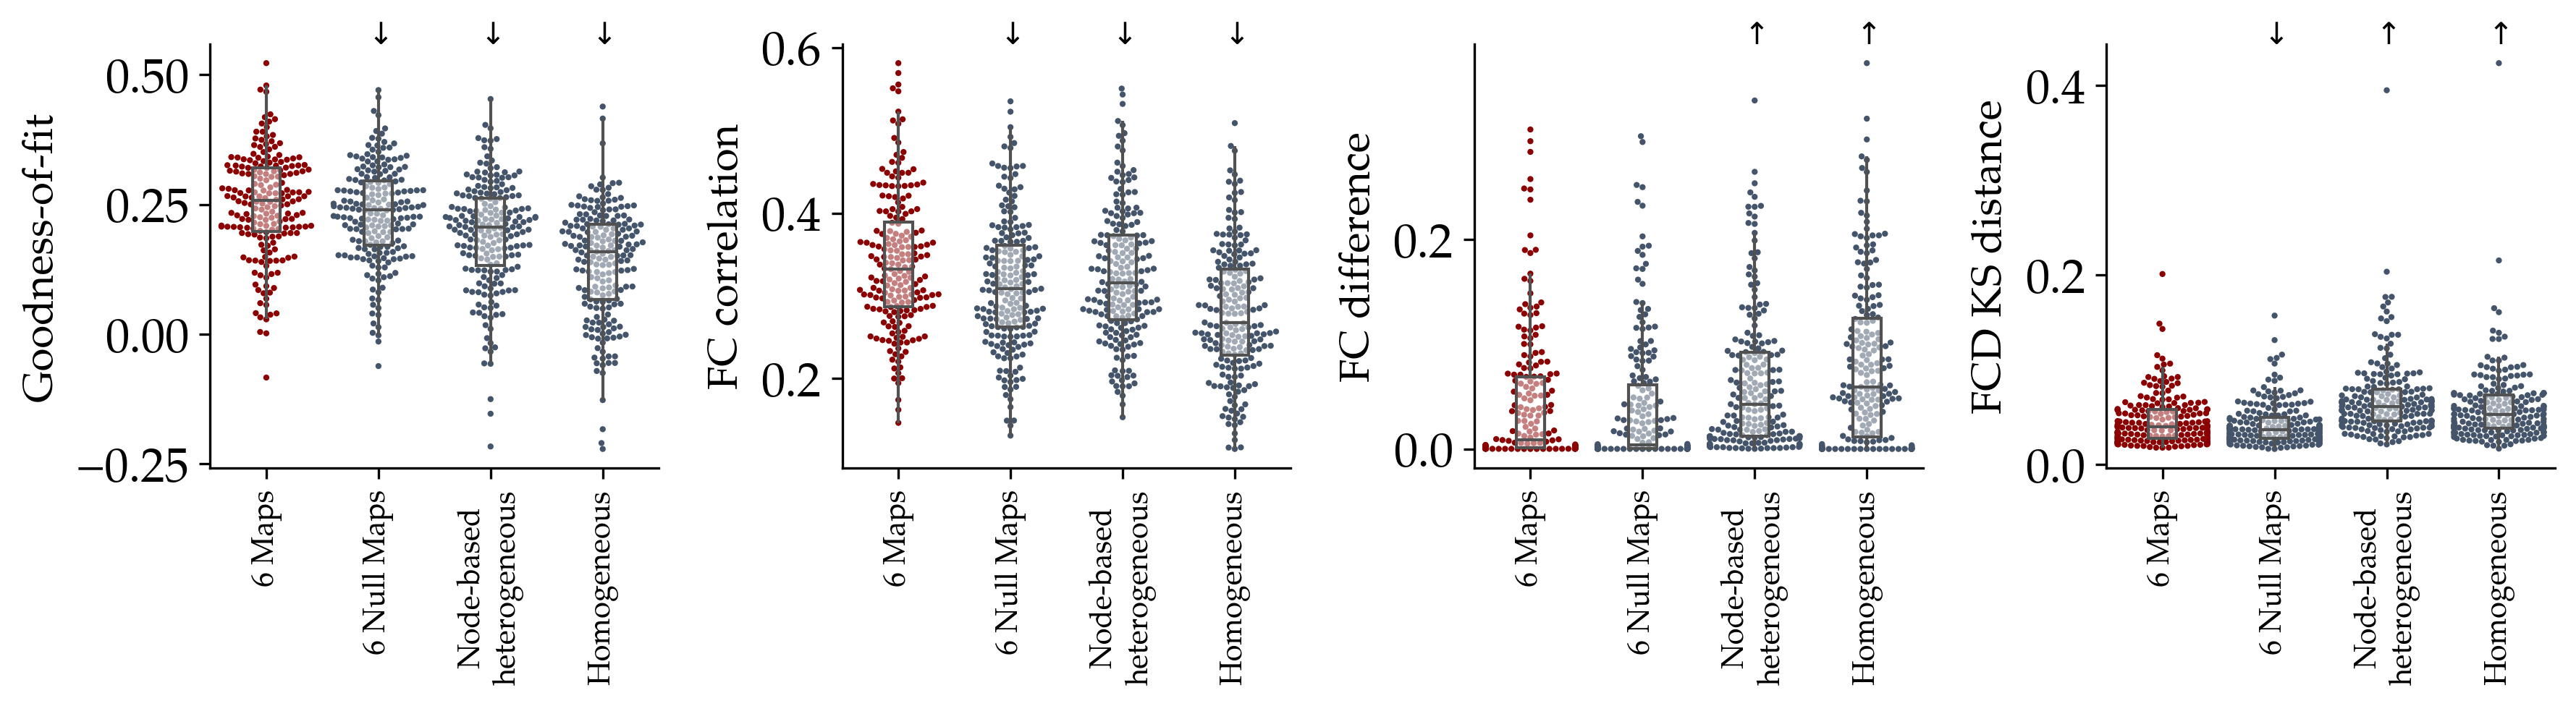

In [17]:
altmodels = ['main', '6maps_rot', 'node', 'homo']
altmodel_labels = ['6 Maps', '6 Null Maps', 'Node-based\nheterogeneous', 'Homogeneous']
data_model_combined = []
for alt in altmodels:
    all_data[alt]['Model'] = alt
    data_model_combined.append(all_data[alt].loc[:, ['gof', 'fc_corr', 'fcd_ks', 'fc_diff', 'Model']])
data_model_combined = pd.concat(data_model_combined, axis=0)
gof_measures = ['gof','fc_corr', 'fc_diff', 'fcd_ks']
fig, axd = plt.subplot_mosaic(
    [gof_measures],
    gridspec_kw=dict(width_ratios=[1]*4, height_ratios=[1]), 
    figsize=(12, 3.5)
)

for i, col in enumerate(gof_measures):
    label = gof_labels[col]
    ax = axd[col]
    sns.swarmplot(
        data=data_model_combined,
        x='Model', y=col, order=altmodels,
        s=2, palette=['darkred']+[thcolor]*6,
        ax=ax
    )
    sns.boxplot(
        data=data_model_combined,
        x='Model', y=col, order=altmodels,
        showfliers=False,
        showcaps=False, width=0.25,
        boxprops={"facecolor": (1, 1, 1, 0.5)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label, fontsize=14)
    ax.set_xlabel('')
    ax.set_xticklabels(altmodel_labels, rotation=90, fontsize=10)
    sns.despine()
    # statistics
    for j, alt in enumerate(altmodels[1:]):
        t, p = scipy.stats.ttest_rel(
            data_model_combined.loc[data_model_combined['Model']==alt, col],
            data_model_combined.loc[data_model_combined['Model']=='main', col]
        )
        if p < 0.05:
            text_x = j+0.85
            text_y = ax.get_ylim()[1]
            if t < 0:
                text = r'$\downarrow$'
            else:
                text = r'$\uparrow$'
            # text = '*'
            ax.text(text_x, text_y, text, fontsize=10, multialignment='center')
        mean_diff = (
            data_model_combined.loc[data_model_combined['Model']==alt, col] -
            data_model_combined.loc[data_model_combined['Model']=='main', col]
        ).mean()
        sd_diff = (
            data_model_combined.loc[data_model_combined['Model']==alt, col] -
            data_model_combined.loc[data_model_combined['Model']=='main', col]
        ).std()
        print(f"{label}: {alt} - main: t = {round(t, 3)}, p = {round(p,3)}, mean_diff = {round(mean_diff, 3)}, sd_diff = {round(sd_diff, 3)}")
fig.tight_layout(pad=1.0)

## C. Comparison of optimizer convergence in map-based versus node-independent models

Load the CMAES history of each model (main versus node-indendent) and each subsample subject, and calculate the range of GOF in the last generation as a measure of convergence:

In [26]:
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"

last_range = pd.DataFrame(columns=['maps', 'node'], dtype=float)
for sub in tqdm(all_data['main'].index):
    # map-based default
    cmaes_folder = os.path.join(
        OUTPUT_DIR["pnc"],
        "sim",
        sub,
        "ctx_parc-schaefer-100_mean001_thresh-1",
        "6maps_schaefer-100_zscore",
        "cmaes_multimaps_gpu",
    )
    hist_maps, _, _ = load_cmaes_hist(
        cmaes_folder, params, het_params, SeedMW=1
    )
    hist_maps["iteration"] = hist_maps["iteration"].astype("int")
    hist_maps['gof'] += 1 # an extra -1 was added to gof during CMAES in these runs; remove it
    last_gof = hist_maps.loc[hist_maps['iteration']==hist_maps['iteration'].max(), 'gof']
    last_range.loc[sub, 'maps'] = last_gof.max() - last_gof.min()
    # node-independent
    hist_node = pd.read_csv(
        os.path.join(
            OUTPUT_DIR["pnc"],
            "sim", sub, 'ctx_parc-schaefer-100_mean001', 
            'node', 'cmaes_run-0', 'history.csv'
        ), index_col=0
    )
    last_gen = hist_node['gen'].max()
    if hist_node.loc[hist_node['gen']==last_gen].shape[0] == 1:
        # when early stop happens last gen will run the optimal simulation
        # and has a single particle
        last_gen = last_gen-1
    last_gof = hist_node.loc[hist_node['gen']==last_gen, '+gof']
    last_range.loc[sub, 'node'] = last_gof.max() - last_gof.min()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]


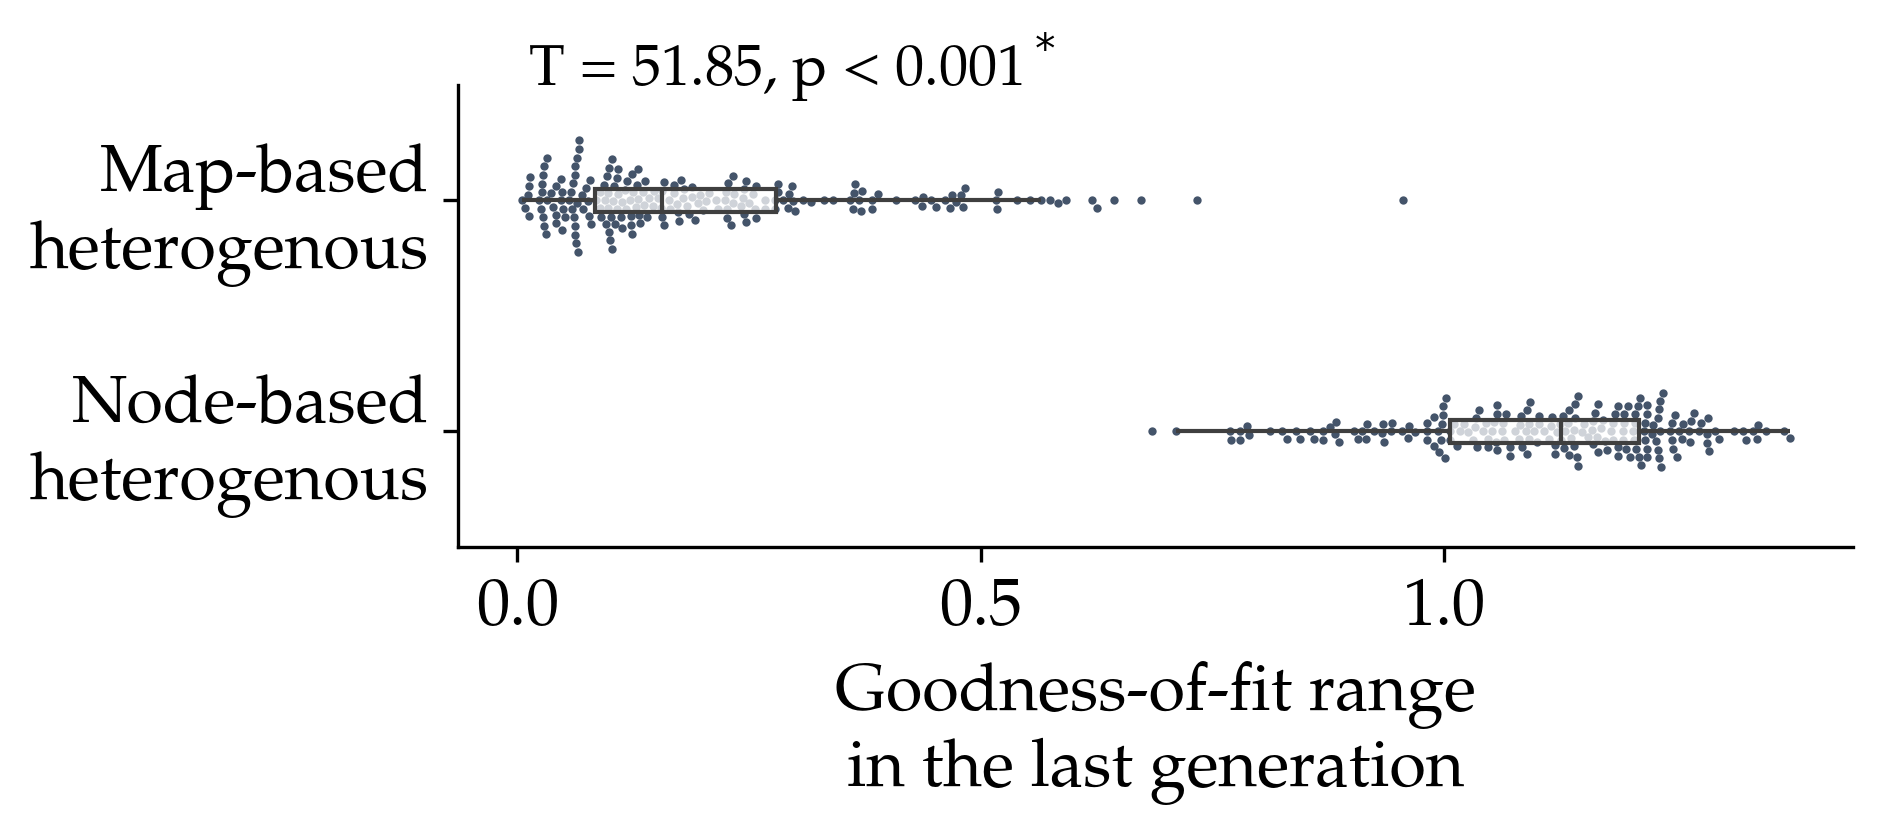

In [27]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_data = last_range.unstack().reset_index()
sns.swarmplot(
    data=plot_data,
    y='level_0', x=0,
    s=2, color=thcolor,
    ax=ax
)
sns.boxplot(
    data=plot_data,
    y='level_0', x=0,
    showfliers=False,
    showcaps=False, width=0.1,
    boxprops={"facecolor": (1, 1, 1, 0.75)},
    ax=ax)
plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
ax.set_xlabel('Goodness-of-fit range\nin the last generation')
ax.set_yticklabels(['Map-based\nheterogenous', 'Node-based\nheterogenous'])
ax.set_ylabel('')
sns.despine()
# add statistics
t, p = scipy.stats.ttest_rel(
    last_range['node'], 
    last_range['maps'])
if add_text:
    if p > 0.001:
        text = f'T = {t:.2f}, p = {p:.3f}'
    else:
        text = f'T = {t:.2f}, p < 0.001'
    if p < 0.05:
        text+=r'$^*$'
    text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
    text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
    ax.text(text_x, text_y, 
            text,
            color='black',
            size=14,
            multialignment='left')

Plot GOF history of the last subject as an example:

(-1.4486158500000001, 0.41093084999999996)

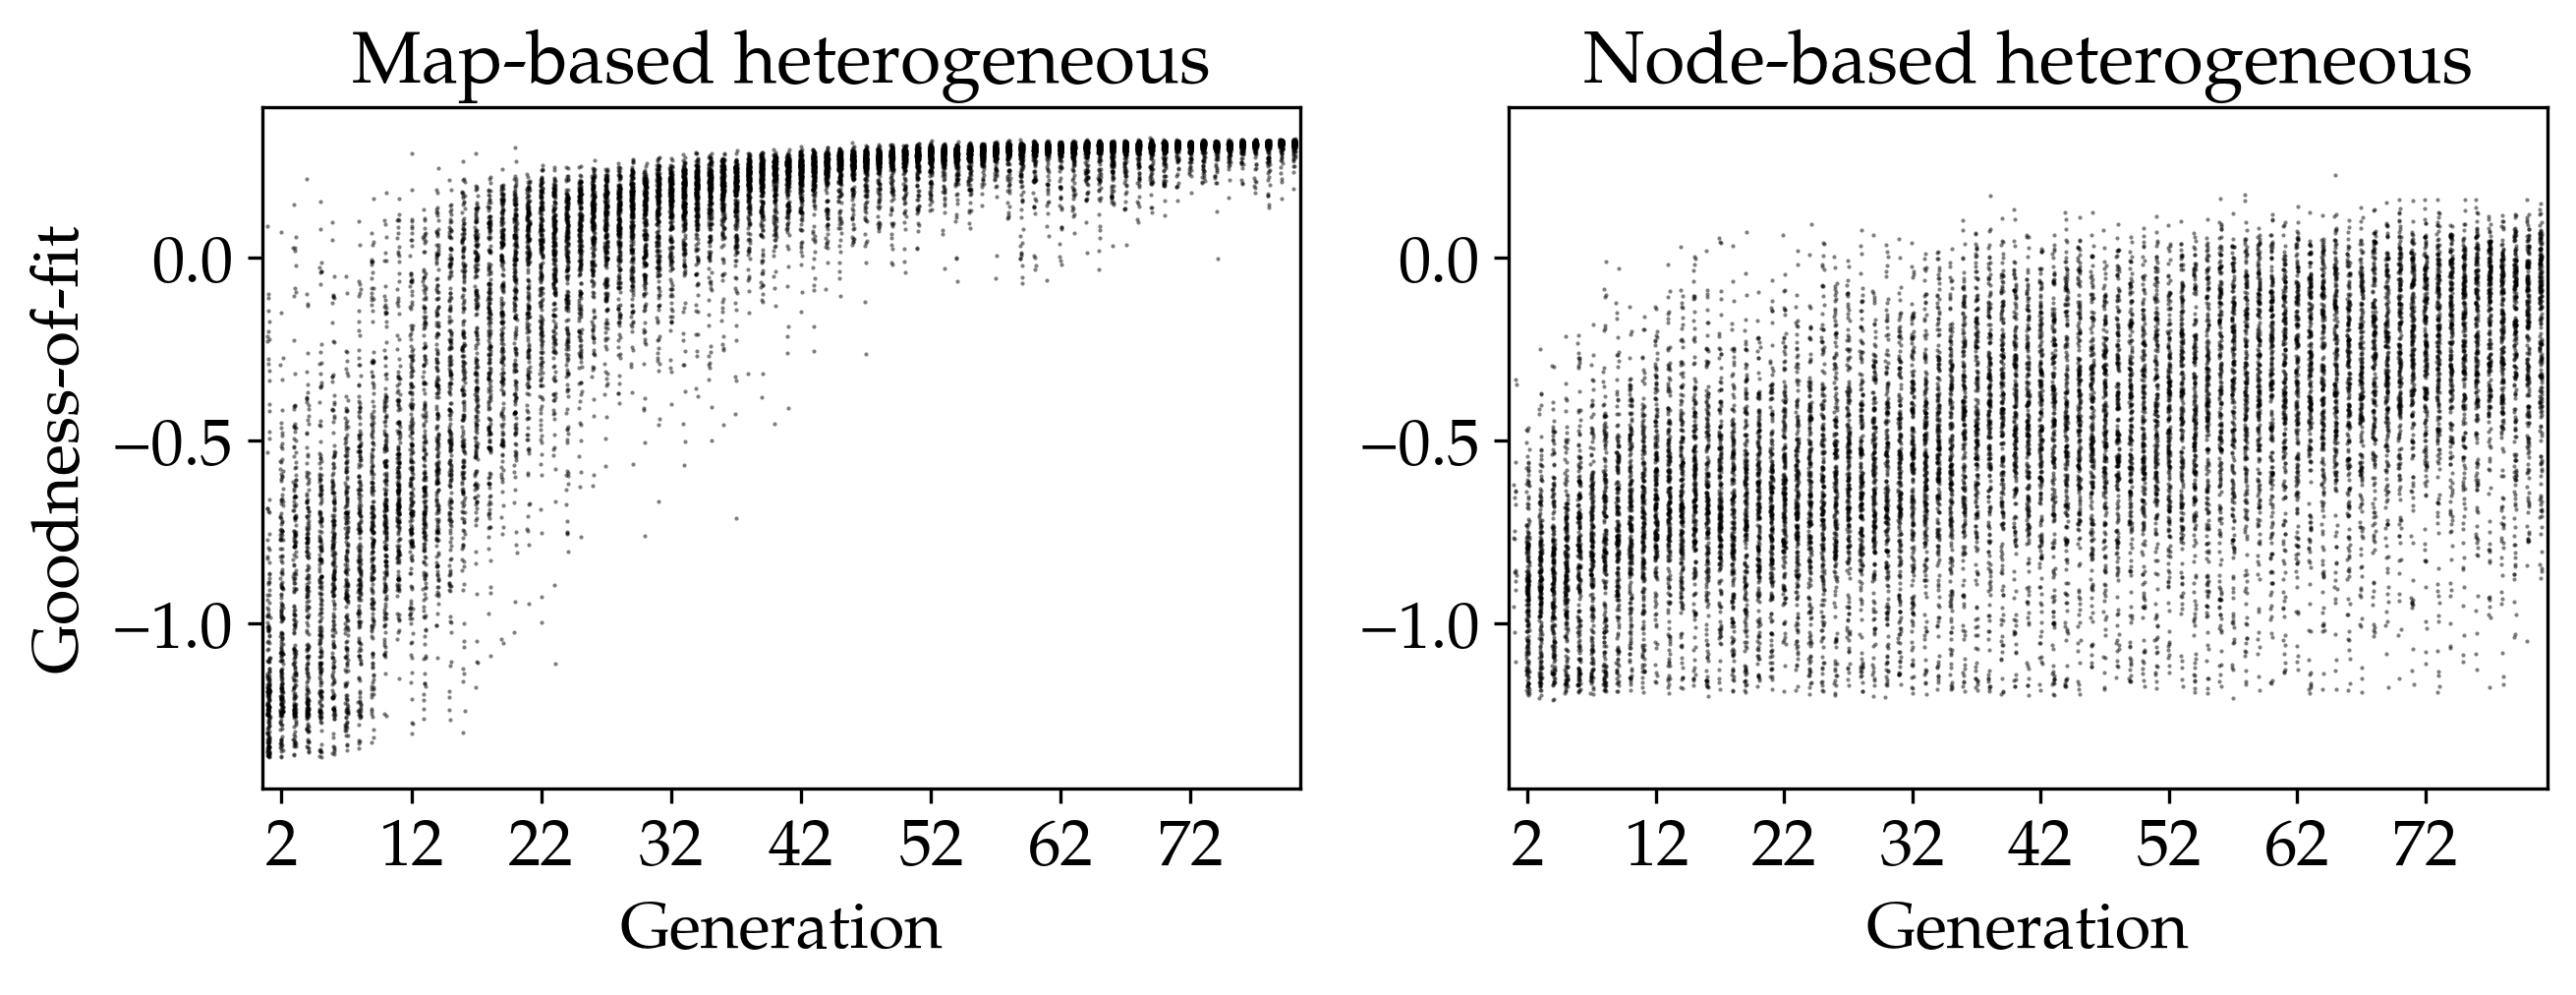

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax_maps, ax_node = axes
sns.stripplot(data=hist_maps, x="iteration", y="gof", s=1, alpha=0.5, color="black", ax=ax_maps)
ax_maps.set_xticks(np.arange(1, 81, 10))
ax_maps.set_ylabel("Goodness-of-fit")
ax_maps.set_xlabel("Generation")
ax_maps.set_title('Map-based heterogeneous', fontsize=18)

# node-independent
sns.stripplot(data=hist_node, x="gen", y="+gof", s=1, alpha=0.5, color="black", ax=ax_node)
ax_node.set_xticks(np.arange(1, 81, 10))
ax_node.set_ylabel("")
ax_node.set_xlabel("Generation")
ax_node.set_title('Node-based heterogeneous', fontsize=18)

# align ylim
ylim = (
    min(ax_maps.get_ylim()[0], ax_node.get_ylim()[0]),
    max(ax_maps.get_ylim()[1], ax_node.get_ylim()[1])
)
ax_maps.set_ylim(ylim)
ax_node.set_ylim(ylim)

## D. Effect of age on E-I ratio in map-free models

### (left) Homogeneous 

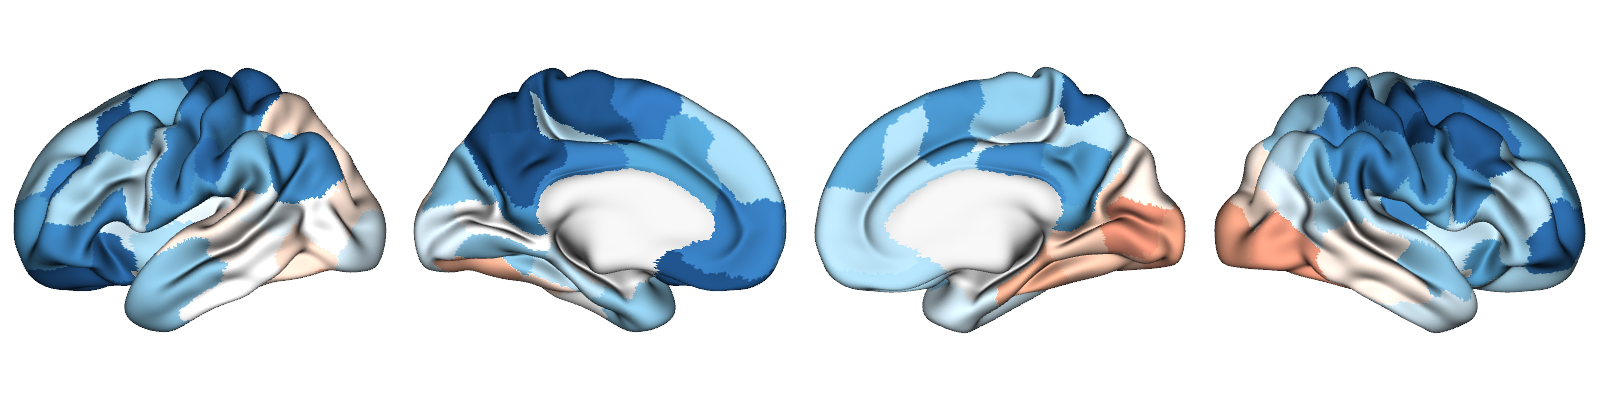

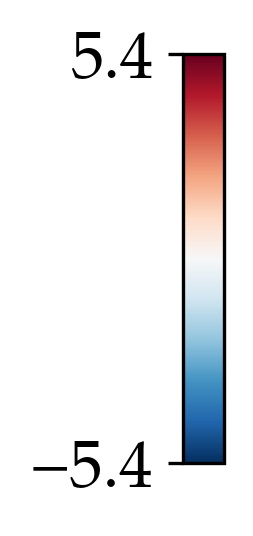

In [29]:
vmin = min(all_stats['homo']['t'].values.min(), -all_stats['homo']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['homo']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

Comparison with main age effect map (the plot is not reported in the figure):

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.3720623164771662 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.6697724160716104 ; p-vlaue: 0.0


<Axes: xlabel='E-I ratio age effect\n(Homogeneous)', ylabel='E-I ratio age effect\n(Map-based)'>

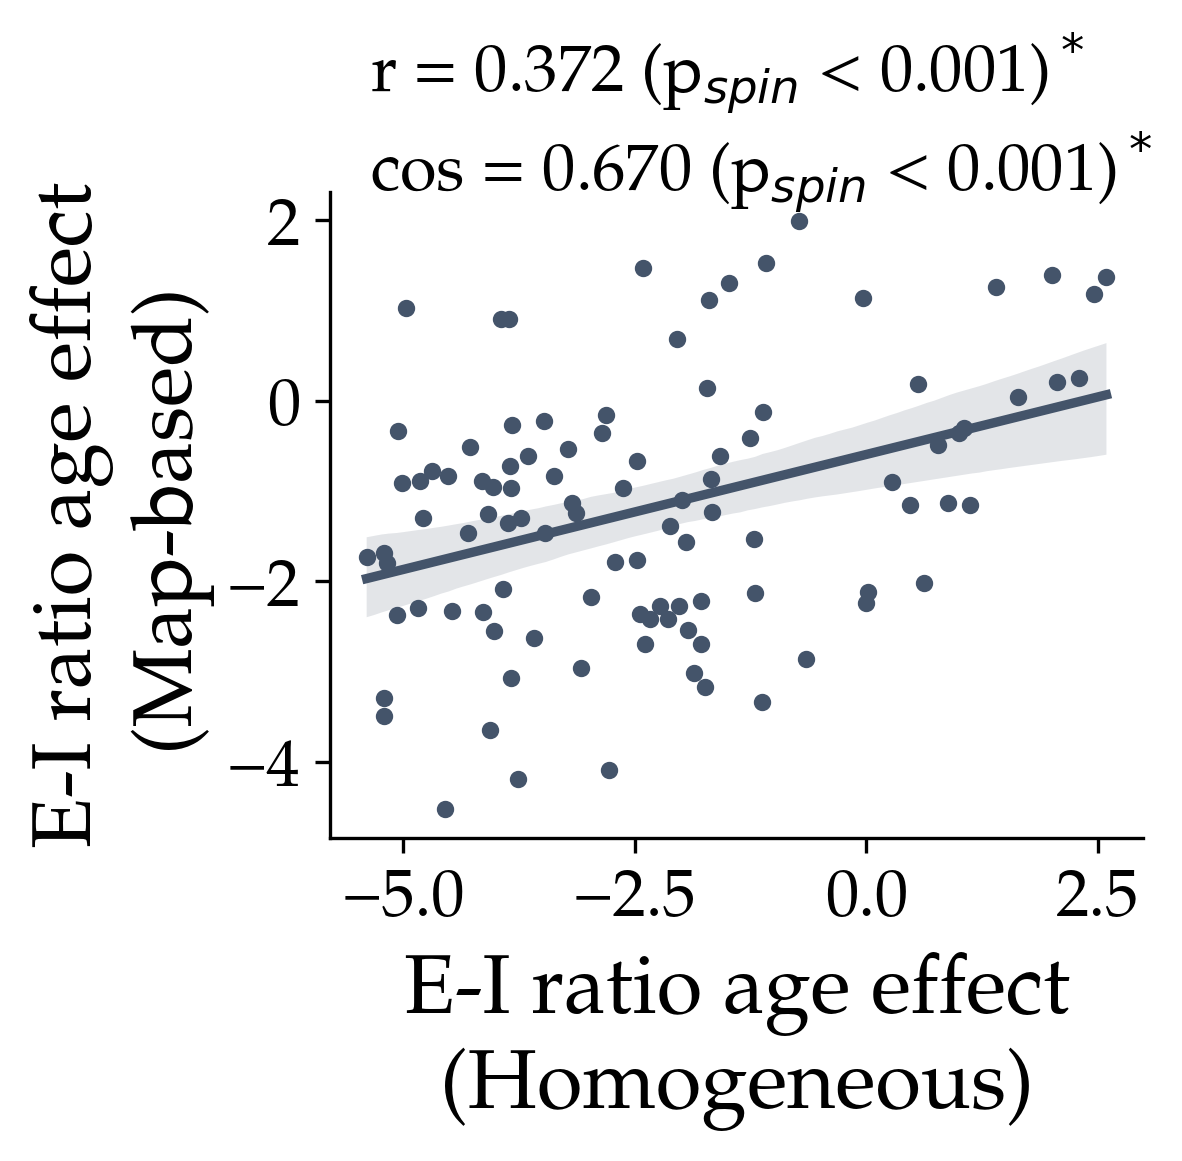

In [30]:
plot.reg_plot(
    all_stats['homo'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel=r'E-I ratio age effect''\n(Homogeneous)',
    ylabel=r'E-I ratio age effect''\n(Map-based)'
)

### (right) Node-independent

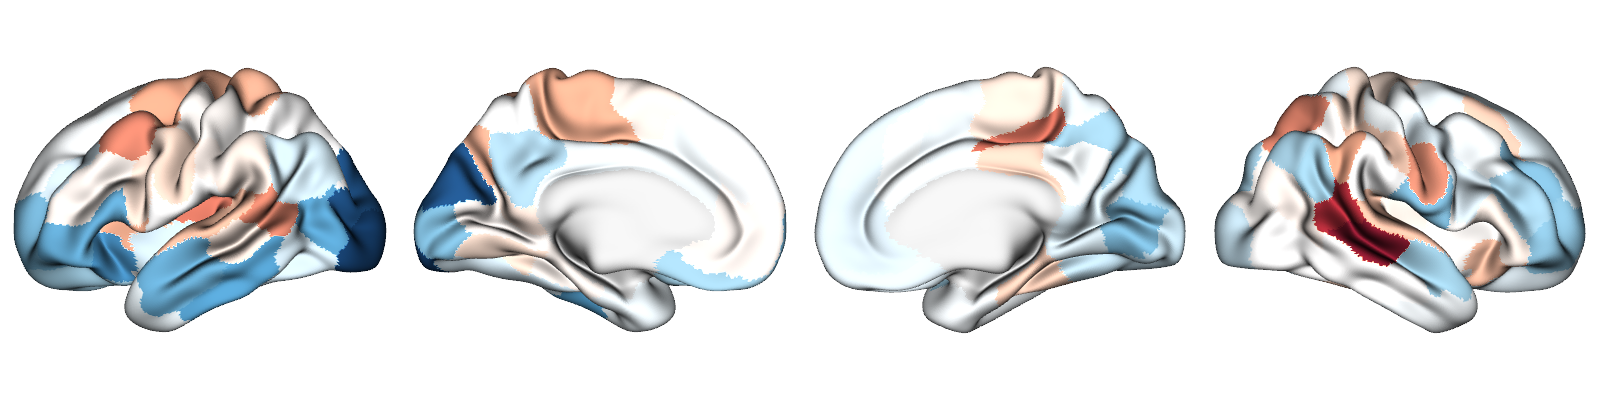

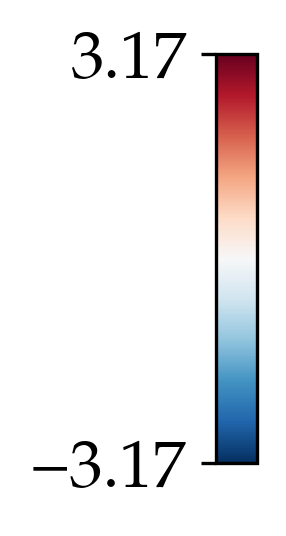

In [31]:
vmin = min(all_stats['node']['t'].values.min(), -all_stats['node']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['node']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

Comparison with main age effect map (the plot is not reported in the figure):

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.10171797822580758 ; p-vlaue: 0.338
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.14387925549429736 ; p-vlaue: 0.167


<Axes: xlabel='E-I ratio age effect\n(Node-independent)', ylabel='E-I ratio age effect\n(Map-based)'>

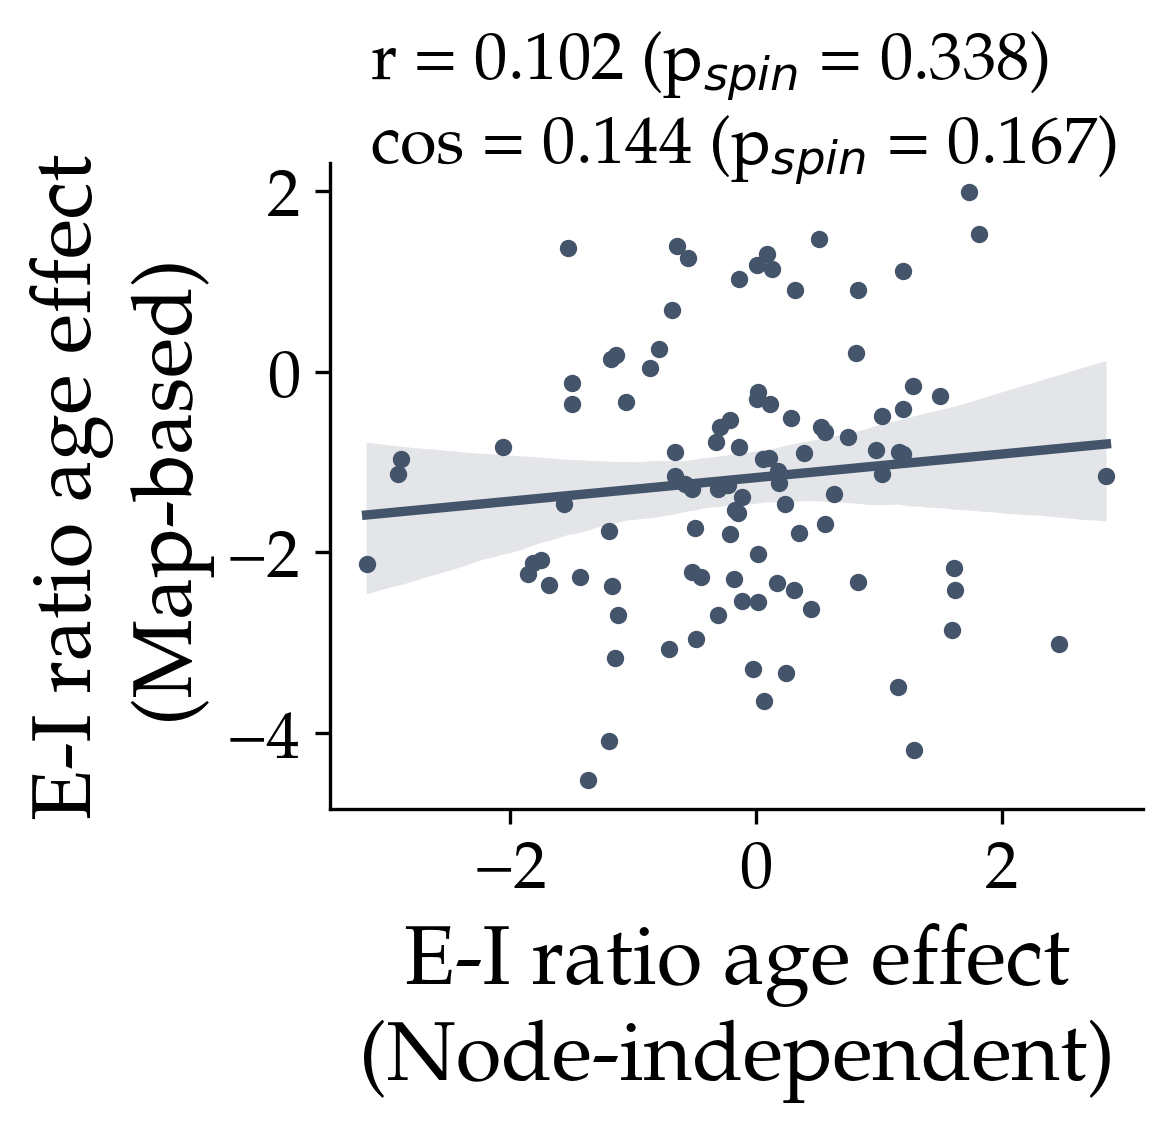

In [32]:
plot.reg_plot(
    all_stats['node'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel=r'E-I ratio age effect''\n(Node-independent)',
    ylabel=r'E-I ratio age effect''\n(Map-based)'
)